In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, os

import tensorflow as tf
from tensorflow import keras


from keras import Input
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import *

import seaborn as sns

In [85]:
VERSION = 'v2'
metrics_list = []

In [86]:
df = pd.read_csv('../../dataset/csv/dataset_v2.csv')
df.head(3)


,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,y74,z74,v74,x75,y75,z75,v75,face_d75,face_s75,hand_s75
0,celinguk,0.515382,0.146067,0.110489,0.991586,0.492822,0.146987,-0.306285,0.994753,0.583330,...,0.719623,-0.075180,0.353278,0.681209,0.719623,-0.075180,0.353278,0.0,1.0,0.0
1,celinguk,0.588917,0.166224,0.116611,0.981934,0.524755,0.146380,-0.193987,0.988952,0.552517,...,0.639301,0.344269,0.393705,0.699179,0.639301,0.344269,0.393705,0.0,1.0,1.0
2,celinguk,0.540433,0.145536,0.037206,0.990441,0.505499,0.144599,-0.328299,0.995738,0.600953,...,0.679823,-0.150806,0.291771,0.627676,0.679823,-0.150806,0.291771,0.0,1.0,0.0


In [87]:
df[df.isnull().any(axis=1)]

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,y74,z74,v74,x75,y75,z75,v75,face_d75,face_s75,hand_s75


In [88]:
df['class'].value_counts()



class
celinguk       200
diam           200
tutupmuka      200
tutuptangan    200
nodong         200
Name: count, dtype: int64

In [89]:
X = df.drop('class', axis=1) # features
y = df['class'] # target value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
y_test

Train set size: 850
Test set size: 150


681    tutuptangan
990         nodong
155       celinguk
768    tutuptangan
438      tutupmuka
          ...     
987         nodong
67        celinguk
375           diam
137       celinguk
148       celinguk
Name: class, Length: 150, dtype: object

# SVC : Training Model

In [90]:
model = make_pipeline(StandardScaler(), SVC(probability=True)).fit(X_train, y_train)
y_probs = model.predict_proba(X_train)

In [91]:

path = f'../../model/trained/svc/'
os.makedirs(os.path.dirname(path), exist_ok=True)

with open(f'{path}/svc_model_{VERSION}.pkl', 'wb') as f:
    pickle.dump(model, f)


Classification Report (Training Data):
              precision    recall  f1-score   support

    celinguk     0.9821    0.9706    0.9763       170
        diam     0.9351    1.0000    0.9665       173
      nodong     0.9337    0.9337    0.9337       166
   tutupmuka     0.9748    0.9281    0.9509       167
 tutuptangan     1.0000    0.9885    0.9942       174

    accuracy                         0.9647       850
   macro avg     0.9652    0.9642    0.9643       850
weighted avg     0.9653    0.9647    0.9647       850



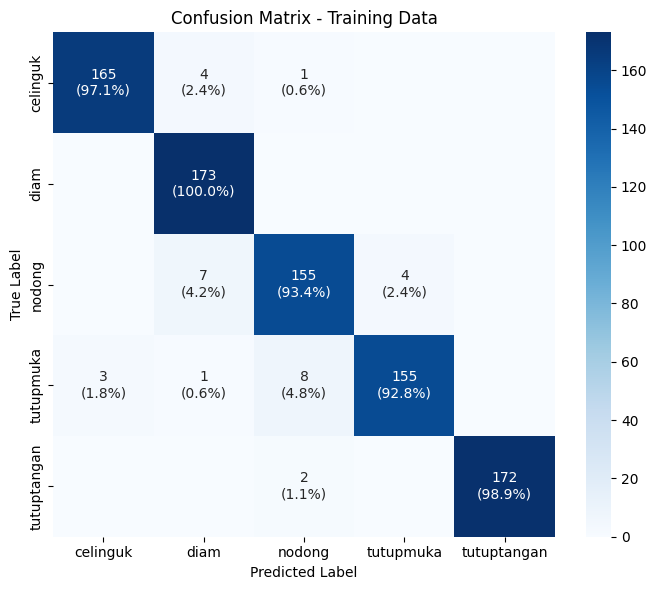

In [92]:
y_pred = model.predict(X_train)

print("\nClassification Report (Training Data):")
print(classification_report(y_train, y_pred, digits=4))

cm = confusion_matrix(y_train, y_pred, labels=np.unique(y_train))
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = (cm / cm_sum.astype(float)) * 100

report_dict = classification_report(y_train, y_pred, digits=4, output_dict=True)

macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
accuracy = report_dict['accuracy']
macro_f1 = report_dict['macro avg']['f1-score']

metrics_list.append({
    'svc': {
        'precision': macro_precision,
        'recall': macro_recall,
        'accuracy': accuracy,
        'f1-score': macro_f1
    }
})

annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if c == 0:
            annot[i, j] = ""
        else:
            annot[i, j] = f"{c}\n({p:.1f}%)"

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    cbar=True,
    xticklabels=np.unique(y_train),
    yticklabels=np.unique(y_train)
)
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [101]:
print(metrics_list)

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}]


# Training Model : LSTM SINGLE

In [102]:
# Separate features (X) and labels (y)
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

# Encode Labels (for multi-class classification)
# Assuming 'diam' is just one class and there might be others in a full dataset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [103]:
def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

def evaluate_model(model, X_test, y_test, title, label_encoder=label_encoder):
    print(f"\n{'='*60}")
    print(f"{title} - Evaluation Results")
    print("="*60)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    y_pred = model.predict(X_test, verbose=0)

    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    y_pred_classes = np.argmax(y_pred, axis=1)

    if label_encoder is not None:
        y_true_labels = label_encoder.inverse_transform(y_true)
        y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
        target_names = label_encoder.classes_
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred_classes
        target_names = None

    

    # 2. Get Classification Report as a Dictionary (Key Change!)
    report_dict = classification_report(y_true_labels, y_pred_labels, 
                                        digits=4, 
                                        output_dict=True, # This returns a dictionary
                                        zero_division=0)
    
    macro_precision = report_dict['macro avg']['precision']
    macro_recall = report_dict['macro avg']['recall']
    macro_f1 = report_dict['macro avg']['f1-score']

    metrics_list.append({
        title: {
            'precision': macro_precision,
            'recall': macro_recall,
            'accuracy': accuracy,
            'f1-score': macro_f1,
        }
    })

    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, digits=4))


    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=target_names)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = (cm / cm_sum.astype(float)) * 100

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{c}\n({p:.1f}%)"

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [96]:
# Reshape for LSTM (Single Timestep) ---
# Format: [samples, timesteps, features]
N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1 # Each row is treated as one observation with one timestep

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

In [97]:
if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    # If it's effectively binary (N_CLASSES=2), we still use sparse_categorical_crossentropy 
    # since we kept y_encoded as integer labels
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    # If N_CLASSES=2, the Dense layer should have 1 unit with 'sigmoid' for binary_crossentropy
    # or N_CLASSES units with 'softmax' for categorical_crossentropy. 
    # Since we use sparse_categorical_crossentropy with integer labels, N_CLASSES with 'softmax' is safest.
    output_activation = 'softmax'

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

In [99]:
lstm_model = Sequential([
    # Single LSTM Layer (no return_sequences since it's the last recurrent layer)
    LSTM(units=128, activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)),
    Dropout(0.3),
    # Output Dense layer
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_s/single_lstm_weights_{VERSION}.best.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

lstm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)



print(f"\nModel Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 100)
lstm_model.summary()
print("-" * 100)

# Training (using the split training data)
print("Starting Model Training...")
history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    verbose=0,
    validation_split=0.2,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 100)


Model Input Shape: (1, 345)
Model Output Classes: 5
----------------------------------------------------------------------------------------------------


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │       242,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,333 (950.52 KB)

 Trainable params: 243,333 (950.52 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------------------------------------------------------------------------
Starting Model Training...

Epoch 1: val_loss improved from None to 0.56156, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 2: val_loss improved from 0.56156 to 0.43067, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 3: val_loss improved from 0.43067 to 0.40297, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 4: val_loss improved from 0.40297 to 0.33750, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 5: val_loss did not improve from 0.33750

Epoch 6: val_loss improved from 0.33750 to 0.24650, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 7: val_loss improved from 0.24650 to 0.23164, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 8: val_loss improved from 0.23164 to 0.2

In [104]:
# Since TensorFlow models don't pickle reliably, we save the trained 
# Keras model separately and then pickle a dictionary containing the necessary 
# preprocessing objects.

PICKLE_FILENAME = f'lstm_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_s/lstm_weights_{VERSION}.keras'

# 8a. Save the Keras model in its native format
lstm_model.save(KERAS_MODEL_FILENAME)

# 8b. Create a dictionary of necessary artifacts
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 8c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_s/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")
print(f"Trained Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print("\nTo load and use this model, you'll need both files and the TensorFlow code to load the .keras file.")

Preprocessing artifacts (Scaler, Encoder) saved to: lstm_model_v2.pkl
Trained Keras model weights saved to: ../../model/trained/lstm_s/lstm_weights_v2.keras

To load and use this model, you'll need both files and the TensorFlow code to load the .keras file.



s-ltsm - Evaluation Results
Test Accuracy: 97.50%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9512    0.9750    0.9630        40
        diam     1.0000    1.0000    1.0000        40
      nodong     0.9750    0.9750    0.9750        40
   tutupmuka     0.9500    0.9500    0.9500        40
 tutuptangan     1.0000    0.9750    0.9873        40

    accuracy                         0.9750       200
   macro avg     0.9752    0.9750    0.9751       200
weighted avg     0.9752    0.9750    0.9751       200



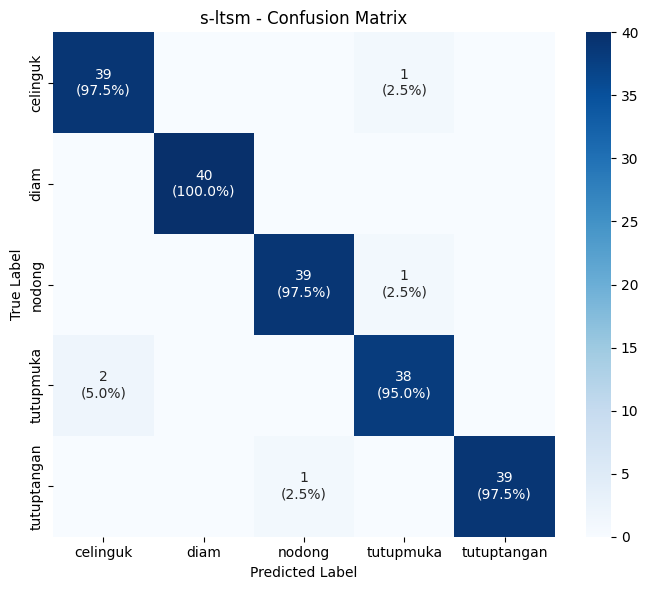

In [105]:
evaluate_model(lstm_model, X_test, y_test, "s-ltsm")

In [106]:
print(metrics_list)

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}, {'s-ltsm': {'precision': 0.9752439024390244, 'recall': 0.975, 'accuracy': 0.9750000238418579, 'f1-score': 0.9750609470229723}}]


# BILSTM : Training Model

In [107]:
bilstm_model = Sequential([
    # Bi-LSTM Layer: Wrap LSTM in Bidirectional
    Bidirectional(LSTM(
        units=128,          # Number of units for EACH direction (Forward and Backward)
        activation='relu'
    ), input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)),
    
    Dropout(0.3),
    
    # Dense layers for classification
    Dense(units=64, activation='relu'),
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# ADD TRANSFORMATION ON BI-LTSM

In [80]:
D_MODEL = 256          # embedding / transformer dimension
NUM_HEADS = 8          # number of attention heads
FF_DIM = 512          # hidden units in feed-forward MLP
DROPOUT_RATE = 0.2

def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.3):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=D_MODEL)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)    # residual connection

    # Feed-forward network (FFN)
    ffn = models.Sequential([ 
        layers.Dense(ff_dim, activation="relu"),
        layers.Dense(D_MODEL),
    ])
    x2 = ffn(x)
    x2 = layers.Dropout(dropout)(x2)
    return layers.LayerNormalization(epsilon=1e-6)(x + x2)     # residual connection


# ======= MODEL =======
inputs = Input(shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE))

# Positional encoding (opsional tapi direkomendasikan)
positions = layers.Embedding(input_dim=N_TIMESTEPS, output_dim=D_MODEL)
pos_ids = layers.Lambda(lambda x: tf.range(tf.shape(x)[1]))(inputs)
x = layers.Dense(D_MODEL)(inputs) + positions(pos_ids)

# Transformer block
x = transformer_encoder(x, num_heads=NUM_HEADS, ff_dim=FF_DIM, dropout=DROPOUT_RATE)

# Pooling untuk keluaran
x = layers.GlobalAveragePooling1D()(x)

# Dense klasifikasi
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(N_CLASSES, activation=output_activation)(x)

transformer_model = models.Model(inputs, outputs)
# transformer_model.summary()

In [81]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_bi/bi_lstm_weights_{VERSION}.best.keras'

loss_fn = 'sparse_categorical_crossentropy'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

transformer_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

# Reshape X_train: (Samples, Features) -> (Samples, 1, Features)

X_train = np.squeeze(X_train) 
X_test = np.squeeze(X_test)

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
# -------------------------------------

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
transformer_model.summary()
print("-" * 50)

print("Starting Transformer Model Training...")
# Train the model
history_transformer = transformer_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = transformer_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1, 345)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (1)               │          0 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 1, 256)    │     88,576 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (1, 256)          │        256 │ lambda_9[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 1, 256)    │          0 │ dense_47[0][0],   │
│                     │                   │            │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 256)    │  2,103,552 │ add_24[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 1, 256)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 1, 256)    │          0 │ dropout_33[0][0], │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 1, 256)    │    262,912 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 1, 256)    │          0 │ sequential_13[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 1, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 64)        │     16,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 5)         │        325 │ dense_50[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,473,093 (9.43 MB)

 Trainable params: 2,473,093 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting Transformer Model Training...


2025-11-15 17:35:59.183034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 48 bytes spill stores, 48 bytes spill loads




Epoch 1: val_loss improved from None to 0.87572, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 2: val_loss did not improve from 0.87572

Epoch 3: val_loss improved from 0.87572 to 0.69246, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 4: val_loss improved from 0.69246 to 0.63377, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 5: val_loss did not improve from 0.63377

Epoch 6: val_loss improved from 0.63377 to 0.46378, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 7: val_loss did not improve from 0.46378

Epoch 8: val_loss did not improve from 0.46378

Epoch 9: val_loss did not improve from 0.46378

Epoch 10: val_loss improved from 0.46378 to 0.39789, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 11: val_loss improved from 0.39789 to 0.36031, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

2025-11-15 17:38:02.181626: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-15 17:38:02.539651: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4 bytes spill loads

2025-11-15 17:38:02.539766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 8 bytes spill stores, 8 bytes spill loads

2025-11-15 17:38:03.663289: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 56 bytes spill s

Test Accuracy: 96.00%
--------------------------------------------------


In [82]:

PICKLE_FILENAME = f'bi_lstm_transform_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'bi_lstm_transform_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
bilstm_model.save(f'../../model/trained/lstm_bi_transform/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_bi_transform/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ BiLSTM Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

FileNotFoundError: [Errno 2] No such file or directory: '../../model/trained/lstm_bi_transform/bi_lstm_transform_weights_v2.keras'


transform - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9500    0.9500    0.9500        40
        diam     1.0000    1.0000    1.0000        40
      nodong     0.9500    0.9500    0.9500        40
   tutupmuka     1.0000    0.9000    0.9474        40
 tutuptangan     0.9091    1.0000    0.9524        40

    accuracy                         0.9600       200
   macro avg     0.9618    0.9600    0.9599       200
weighted avg     0.9618    0.9600    0.9599       200



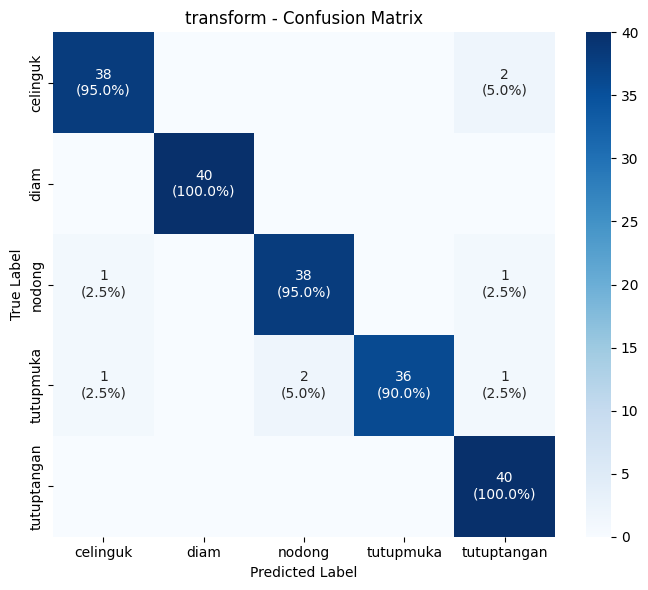

[{'svc': {'precision': 96.51711398665253, 'recall': 96.41945269508882, 'accuracy': 96.47058823529412, 'f1-score': 96.4337329242224}}, {'s-ltsm': {'precision': 95.6802343997466, 'recall': 95.5, 'accuracy': 95.49999833106995, 'f1-score': 95.46402116402115}}, {'bi-ltsm': {'precision': 96.62052417866371, 'recall': 96.50000000000001, 'accuracy': 96.49999737739563, 'f1-score': 96.4693867522543}}, {'gru': {'precision': 95.64617726960624, 'recall': 95.49999999999999, 'accuracy': 95.49999833106995, 'f1-score': 95.52772161892186}}, {'neural network': {'precision': 97.06959706959708, 'recall': 97.0, 'accuracy': 97.00000286102295, 'f1-score': 96.97934667987154}}, {'bi-lstm-transform': {'precision': 0.9599749843652283, 'recall': 0.96, 'accuracy': 0.9599999785423279, 'f1-score': 0.9598687294889826}}, {'bi-lstm-transform': {'precision': 0.9702067786727607, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9698014684517722}}, {'transform': {'precision': 0.9702067786727607, 'recall': 0.97, 

In [83]:
evaluate_model(transformer_model, X_test, y_test, "transform")
print(metrics_list)

# BI-LTSM Wihtou Transofrmation

In [108]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_bi/bi_lstm_weights_{VERSION}.best.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

bilstm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
bilstm_model.summary()
print("-" * 50)

print("Starting BiLSTM Model Training...")
# Train the model
history_bilstm = bilstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,149 (1.92 MB)

 Trainable params: 502,149 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting BiLSTM Model Training...

Epoch 1: val_loss improved from None to 0.53854, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 2: val_loss improved from 0.53854 to 0.37394, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 3: val_loss improved from 0.37394 to 0.25148, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 4: val_loss did not improve from 0.25148

Epoch 5: val_loss did not improve from 0.25148

Epoch 6: val_loss did not improve from 0.25148

Epoch 7: val_loss did not improve from 0.25148

Epoch 8: val_loss did not improve from 0.25148

Epoch 9: val_loss did not improve from 0.25148

Epoch 10: val_loss improved from 0.25148 to 0.20613, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 11: val_loss did not improve from 0.20613

Epoch 12: val_loss did not improve from 0.20613

Epoch 13: val_loss imp

In [109]:

PICKLE_FILENAME = f'bi_lstm_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'bi_lstm_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
bilstm_model.save(f'../../model/trained/lstm_bi/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_bi/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ BiLSTM Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ BiLSTM Keras model weights saved to: bi_lstm_weights_v2.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: bi_lstm_model_v2.pkl



bi-ltsm - Evaluation Results
Test Accuracy: 97.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9512    0.9750    0.9630        40
        diam     1.0000    0.9750    0.9873        40
      nodong     0.9512    0.9750    0.9630        40
   tutupmuka     0.9744    0.9500    0.9620        40
 tutuptangan     0.9750    0.9750    0.9750        40

    accuracy                         0.9700       200
   macro avg     0.9704    0.9700    0.9701       200
weighted avg     0.9704    0.9700    0.9701       200



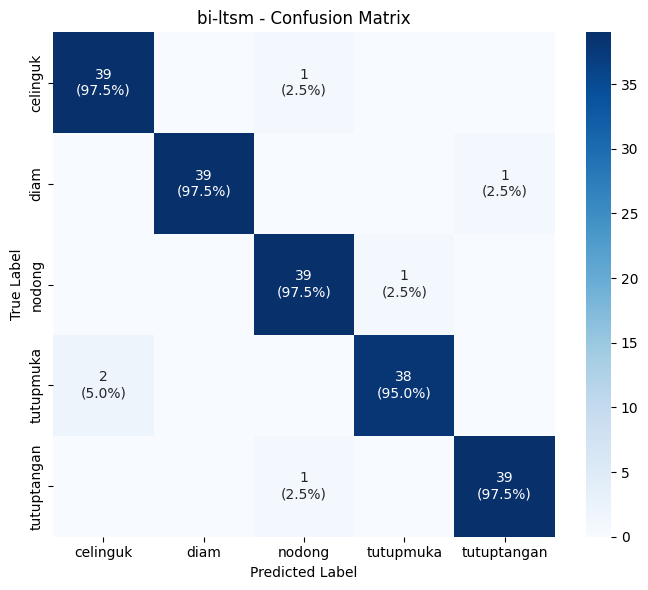

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}, {'s-ltsm': {'precision': 0.9752439024390244, 'recall': 0.975, 'accuracy': 0.9750000238418579, 'f1-score': 0.9750609470229723}}, {'bi-ltsm': {'precision': 0.9703595997498435, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9700586029067042}}]


In [110]:
evaluate_model(bilstm_model, X_test, y_test, "bi-ltsm")
print(metrics_list)

In [111]:
print("--- Model Metrics ---")
for item in metrics_list:
    # Get the model name and its metrics dictionary
    model_name = list(item.keys())[0]
    metrics = item[model_name]
    
    # Print the model name and metrics dictionary
    print(f"**{model_name.upper()} Metrics:**")
    print(metrics)
    print("-" * 25)

--- Model Metrics ---
**SVC Metrics:**
{'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}
-------------------------
**S-LTSM Metrics:**
{'precision': 0.9752439024390244, 'recall': 0.975, 'accuracy': 0.9750000238418579, 'f1-score': 0.9750609470229723}
-------------------------
**BI-LTSM Metrics:**
{'precision': 0.9703595997498435, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9700586029067042}
-------------------------


# GRU : Training Model

In [112]:
# --- 2. Define the Single-Layer GRU Model ---
gru_model = Sequential([
    # GRU Layer - No Bidirectional wrapper requested, so it's unidirectional.
    GRU(
        units=128,          # Number of units in the GRU
        activation='tanh',  # GRU default activation
        input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)
    ),
    
    Dropout(0.3),
    
    # Dense layers for classification
    Dense(units=64, activation='relu'),
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [113]:
KERAS_MODEL_FILENAME = f'../../model/trained/gru/gru_weights_{VERSION}.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

gru_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
gru_model.summary()
print("-" * 50)

print("Starting GRU Model Training...")
# Train the model
history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 128)            │       182,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,981 (746.02 KB)

 Trainable params: 190,981 (746.02 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting GRU Model Training...

Epoch 1: val_loss improved from None to 0.54721, saving model to ../../model/trained/gru/gru_weights_v2.keras

Epoch 2: val_loss improved from 0.54721 to 0.34046, saving model to ../../model/trained/gru/gru_weights_v2.keras

Epoch 3: val_loss improved from 0.34046 to 0.28541, saving model to ../../model/trained/gru/gru_weights_v2.keras

Epoch 4: val_loss improved from 0.28541 to 0.17684, saving model to ../../model/trained/gru/gru_weights_v2.keras

Epoch 5: val_loss did not improve from 0.17684

Epoch 6: val_loss improved from 0.17684 to 0.17647, saving model to ../../model/trained/gru/gru_weights_v2.keras

Epoch 7: val_loss did not improve from 0.17647

Epoch 8: val_loss did not improve from 0.17647

Epoch 9: val_loss did not improve from 0.17647

Epoch 10: val_loss did not improve from 0.17647

Epoch 11: val_loss improved from 0.17647 to 0.15814, saving model to ../../model/trained/gru/gru_weights_v2.k

In [114]:

PICKLE_FILENAME = f'gru_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'gru_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
gru_model.save(f'../../model/trained/gru/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/gru/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ GRU Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ GRU Keras model weights saved to: gru_weights_v2.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: gru_model_v2.pkl



gru - Evaluation Results
Test Accuracy: 97.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9737    0.9250    0.9487        40
        diam     1.0000    1.0000    1.0000        40
      nodong     0.9512    0.9750    0.9630        40
   tutupmuka     0.9286    0.9750    0.9512        40
 tutuptangan     1.0000    0.9750    0.9873        40

    accuracy                         0.9700       200
   macro avg     0.9707    0.9700    0.9700       200
weighted avg     0.9707    0.9700    0.9700       200



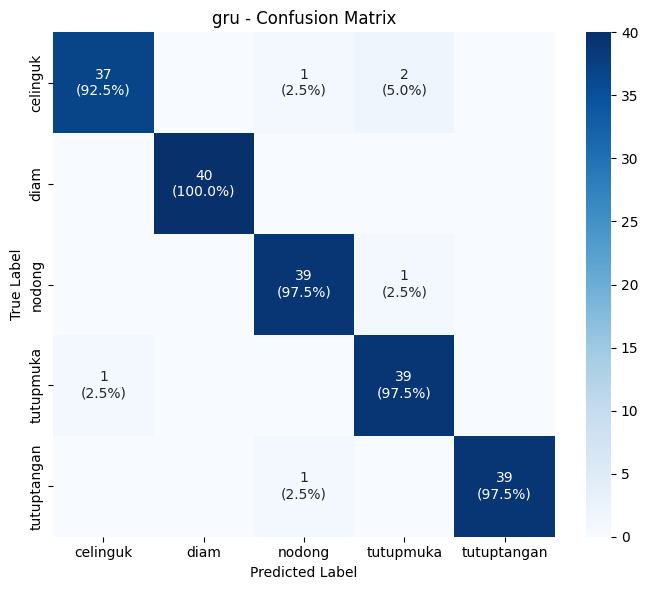

In [115]:
evaluate_model(gru_model, X_test, y_test, "gru")

In [116]:
print("--- Model Metrics ---")
for item in metrics_list:
    # Get the model name and its metrics dictionary
    model_name = list(item.keys())[0]
    metrics = item[model_name]
    
    # Print the model name and metrics dictionary
    print(f"**{model_name.upper()} Metrics:**")
    print(metrics)
    print("-" * 25)

--- Model Metrics ---
**SVC Metrics:**
{'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}
-------------------------
**S-LTSM Metrics:**
{'precision': 0.9752439024390244, 'recall': 0.975, 'accuracy': 0.9750000238418579, 'f1-score': 0.9750609470229723}
-------------------------
**BI-LTSM Metrics:**
{'precision': 0.9703595997498435, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9700586029067042}
-------------------------
**GRU Metrics:**
{'precision': 0.9706950302585733, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9700484392055865}
-------------------------


# NN : Training Model

In [117]:
# --- Configuration ---

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

# Scaling (Crucial for Dense layers)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_SAMPLES = X_scaled.shape[0]

# Note: MLP/Dense layers expect 2D data: [samples, features]
# We use X_scaled directly, NOT the 3D X_reshaped used for LSTMs/GRUs.
X_flat = X_scaled

# Final Output Preparation (Using sparse labels with softmax for consistency)
y_final = y_encoded
loss_fn = 'sparse_categorical_crossentropy'
output_activation = 'softmax'

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_final, test_size=0.2, random_state=42, stratify=y_final
)

In [118]:
nn_model = Sequential([
    # Input layer and first Hidden Dense Layer
    Dense(units=256, activation='relu', input_shape=(N_FEATURES_PER_SAMPLE,)),
    Dropout(0.3),
    
    # Second Hidden Dense Layer
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    
    # Output Dense layer (units = number of classes, activation = softmax for classification)
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [119]:
KERAS_MODEL_FILENAME = f'../../model/trained/nn/nn_weights_{VERSION}.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

nn_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape (NN/MLP): {X_train.shape[1]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
nn_model.summary()
print("-" * 50)

print("Starting MLP Model Training...")
# Train the model
history_nn = nn_model.fit(
    X_train,
    y_train,
    epochs=100, # Use more epochs than RNNs, as simple layers train faster
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[earlystop_cb, checkpoint_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape (NN/MLP): 345
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 256)            │        88,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,117 (477.02 KB)

 Trainable params: 122,117 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting MLP Model Training...

Epoch 1: val_loss improved from None to 0.70952, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 2: val_loss improved from 0.70952 to 0.50240, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 3: val_loss improved from 0.50240 to 0.40777, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 4: val_loss improved from 0.40777 to 0.35164, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 5: val_loss did not improve from 0.35164

Epoch 6: val_loss improved from 0.35164 to 0.32814, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 7: val_loss improved from 0.32814 to 0.26684, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 8: val_loss improved from 0.26684 to 0.24071, saving model to ../../model/trained/nn/nn_weights_v2.keras

Epoch 9: val_loss did not improve from 0.24071

Epoch 10: val_loss did not improve from 

In [120]:

PICKLE_FILENAME = f'nn_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'nn_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
nn_model.save(f'../../model/trained/nn/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/nn/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ NN Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ NN Keras model weights saved to: nn_weights_v2.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: nn_model_v2.pkl



neural network - Evaluation Results
Test Accuracy: 97.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9744    0.9500    0.9620        40
        diam     1.0000    0.9750    0.9873        40
      nodong     0.9750    0.9750    0.9750        40
   tutupmuka     0.9286    0.9750    0.9512        40
 tutuptangan     0.9750    0.9750    0.9750        40

    accuracy                         0.9700       200
   macro avg     0.9706    0.9700    0.9701       200
weighted avg     0.9706    0.9700    0.9701       200



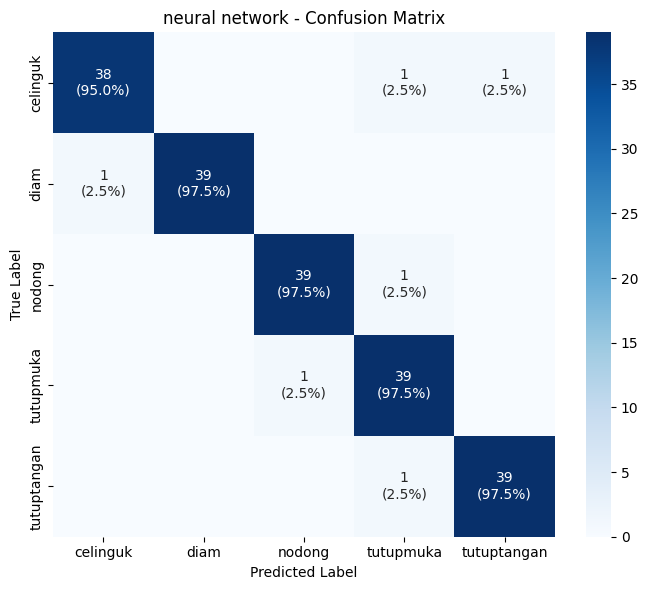

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}, {'s-ltsm': {'precision': 0.9752439024390244, 'recall': 0.975, 'accuracy': 0.9750000238418579, 'f1-score': 0.9750609470229723}}, {'bi-ltsm': {'precision': 0.9703595997498435, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9700586029067042}}, {'gru': {'precision': 0.9706950302585733, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9700484392055865}}, {'neural network': {'precision': 0.9705860805860805, 'recall': 0.97, 'accuracy': 0.9700000286102295, 'f1-score': 0.9701173201605433}}]


In [121]:
evaluate_model(nn_model, X_test, y_test, "neural network")
print(metrics_list)

# Visualization

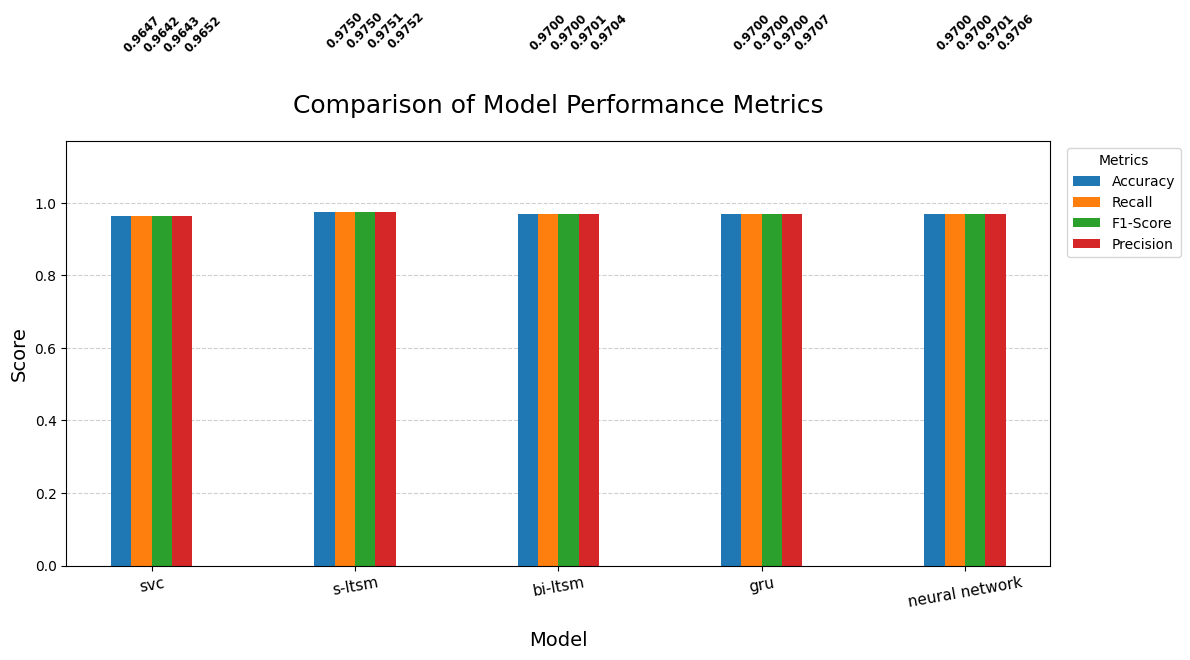

In [ ]:
# --- Data Processing ---
records = []
for model_dict in metrics_list:
    for model_name, metrics in model_dict.items():
        record = {'Model': model_name}
        record.update(metrics)
        records.append(record)

df = pd.DataFrame(records)

df.rename(columns={
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1-score': 'F1-Score'
}, inplace=True)

# --- Plotting Setup ---
metrics = ['Accuracy', 'Recall', 'F1-Score', 'Precision']
x = np.arange(len(df['Model'])) # Label locations (0, 1, 2, ...)
width = 0.1 # Width of the individual bars

fig, ax = plt.subplots(figsize=(12, 7))

# --- Plotting and Labeling Bars ---
max_score = df[metrics].max().max()

for i, metric in enumerate(metrics):
    # Plot the bars and store the BarContainer object in 'bars'
    bars = ax.bar(x + i * width, df[metric], width, label=metric)
    
    # Add the numerical value above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            height + 0.05,                      # Y position (increased offset to account for rotation)
            f'{height:.4f}',                    # Text value (reduced to two decimal places)
            ha='left',                          # Horizontal alignment set to 'left' for rotation pivot
            va='center',                        # Vertical alignment set to 'center'
            rotation=45,                        # ROTATE THE TEXT 45 DEGREES
            fontsize=8.5,                       # Smaller font size
            color='black',
            fontweight='bold'
        )

# --- Chart Customization ---
ax.set_xlabel('Model', fontsize=14, labelpad=15)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Comparison of Model Performance Metrics', fontsize=18, pad=20)
ax.set_xticks(x + width * 1.5) # Center the ticks under the group of bars
ax.set_xticklabels(df['Model'], rotation=10, ha='center', fontsize=11)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title="Metrics")

# Adjust Y-limit to make space for the labels
# Sets y-limit slightly higher than the highest score found in the data
ax.set_ylim(0, max_score * 1.2) # Increased Y-limit slightly more for rotated labels

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_axisbelow(True) # Put grid lines behind the bars
plt.tight_layout()
plt.show()

## LSTM

In [26]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

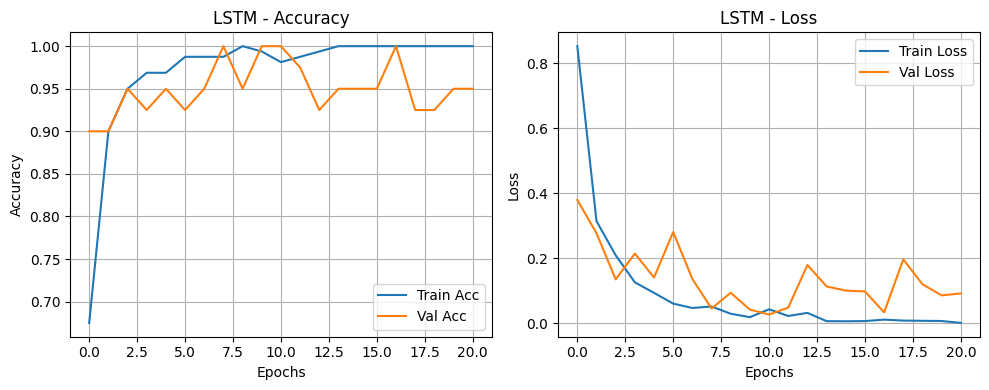

In [25]:
plot_training_history(history_lstm, "LSTM")


LSTM - Evaluation Results
Test Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    1.0000    1.0000        10
        diam     0.9091    1.0000    0.9524        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9800        50
   macro avg     0.9818    0.9800    0.9799        50
weighted avg     0.9818    0.9800    0.9799        50



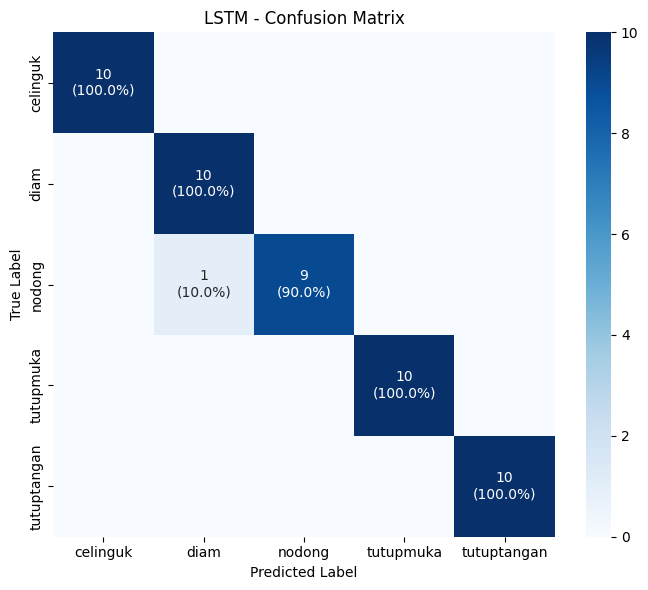

In [27]:
evaluate_model(lstm_model, X_test, y_test, "LSTM")

## BI-LSTM

In [29]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

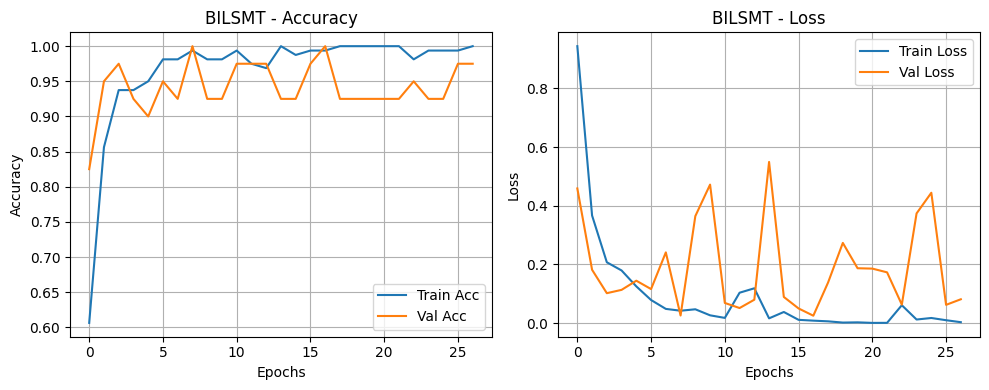

In [31]:
plot_training_history(history_bilstm, "BILSMT")


BI-LSTM - Evaluation Results
Test Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    1.0000    1.0000        10
        diam     0.9091    1.0000    0.9524        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9800        50
   macro avg     0.9818    0.9800    0.9799        50
weighted avg     0.9818    0.9800    0.9799        50



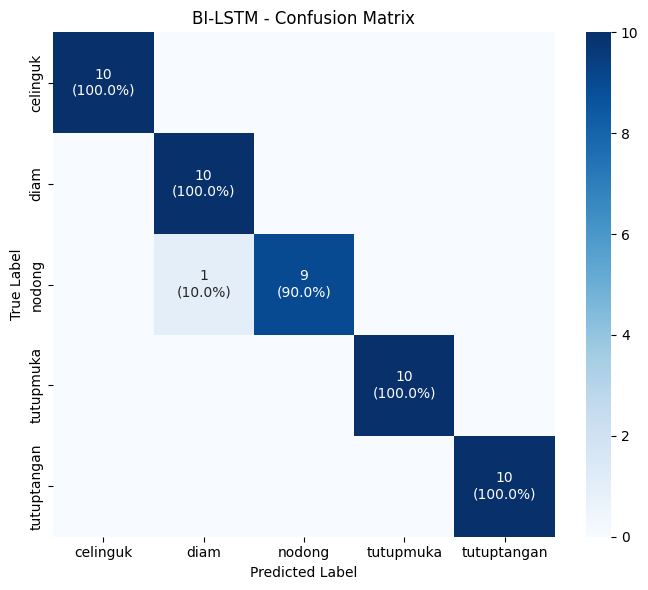

In [30]:
evaluate_model(bilstm_model, X_test, y_test, "BI-LSTM")

## GRU

In [32]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

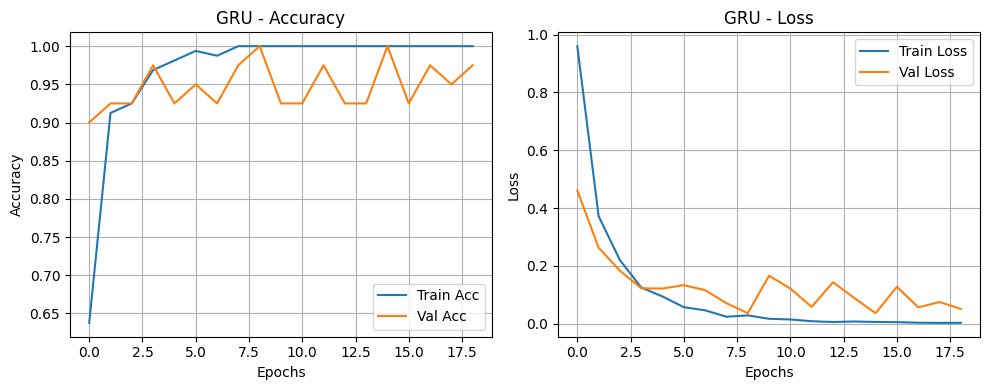

In [33]:
plot_training_history(history_gru, "GRU")


GRU - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9091    1.0000    0.9524        10
        diam     0.9000    0.9000    0.9000        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9618    0.9600    0.9599        50
weighted avg     0.9618    0.9600    0.9599        50



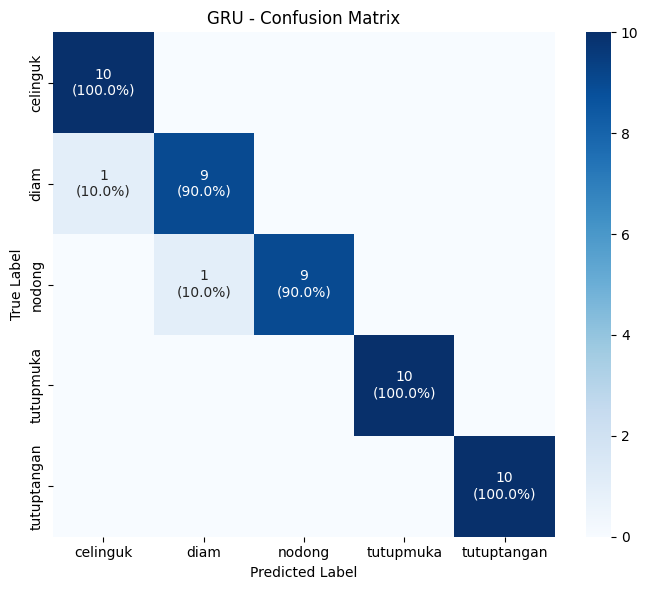

In [34]:
evaluate_model(gru_model, X_test, y_test, "GRU")

## NN

In [36]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_SAMPLES = X_scaled.shape[0]

X_flat = X_scaled

y_final = y_encoded
loss_fn = 'sparse_categorical_crossentropy'
output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_final, test_size=0.2, random_state=42, stratify=y_final
)

X_train = X_train.squeeze()
X_test = X_test.squeeze()

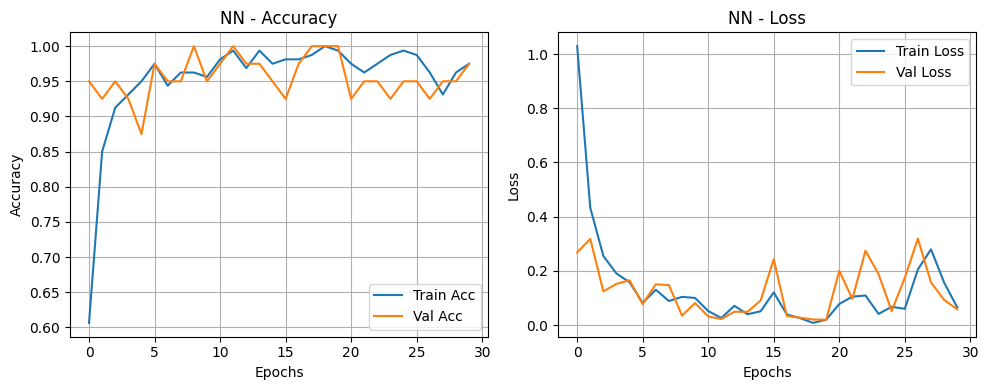

In [37]:
plot_training_history(history_nn, "NN")


NN - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    0.8000    0.8889        10
        diam     0.8333    1.0000    0.9091        10
      nodong     1.0000    1.0000    1.0000        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9667    0.9600    0.9596        50
weighted avg     0.9667    0.9600    0.9596        50



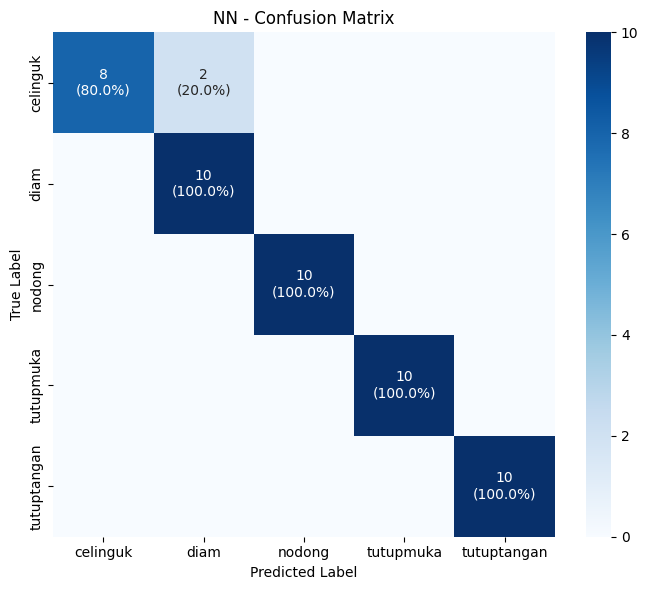

In [38]:
evaluate_model(nn_model, X_test, y_test, "NN")